<a href="https://colab.research.google.com/github/gaiobr/aprendizado-de-maquina-edge-ufal/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dados de Temperatura (algumas cidades brasileiras)**

Dataset com séries temporais de temperaturas de algumas cidades do Brasil.

https://www.kaggle.com/volpatto/temperature-timeseries-for-some-brazilian-cities



In [307]:
  from google.colab import drive
  drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **1. Importar bibliotecas**

In [308]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## **2. Carregar conjunto de dados**

In [309]:
# Carregar dataset SALVADOR
df_ssa = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/climate/station_salvador.csv')

In [312]:
df = df_ssa

In [313]:
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1961,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,24.97,999.90,999.90,999.90,999.90,999.90
1,1962,26.07,25.97,26.07,25.77,24.47,23.37,22.47,22.47,23.37,22.97,24.67,25.18,25.67,25.44,22.77,23.67,24.39
2,1963,999.90,25.78,26.38,25.68,23.68,999.90,22.08,22.38,23.08,24.18,24.88,24.67,25.51,25.25,22.46,24.05,24.32
3,1964,25.27,25.67,25.47,24.97,24.07,23.07,22.77,22.77,23.27,23.77,23.87,24.46,25.20,24.84,22.87,23.64,24.14
4,1965,24.96,25.76,26.06,24.96,24.56,23.56,23.26,22.86,23.66,24.36,24.86,25.35,25.06,25.19,23.23,24.29,24.44


## **3. Limpar e organizar os dados**

In [314]:
# Verificar e excluir valores NaN, ? ou dados faltantes
df = df.drop(df.index[0])

In [315]:
df = df.replace(999.90, np.nan)

### 3.1 Dataset Anual

In [316]:
df_year = df[['YEAR', 'metANN']]
df_year.head()

,YEAR,metANN
1,1962,24.39
2,1963,24.32
3,1964,24.14
4,1965,24.44
5,1966,24.32


### 3.2 Dataset Mensal

In [322]:
# Excluir colunas
df_month = df.drop(columns=['D-J-F', 'M-A-M', 'J-J-A', 'S-O-N', 'metANN'])

In [323]:
df_month = df_month.melt(id_vars=["YEAR"], 
        var_name="MONTH", 
        value_name="VALUE")


In [324]:
df_month = df_month.dropna()


In [325]:
months = {'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6, 
          'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}
df_month.MONTH = df_month.MONTH.map(months)


In [326]:
df_month['DATE'] = pd.to_datetime(df_month[['YEAR', 'MONTH']].assign(DAY=1))

In [327]:
df_month = df_month.sort_values(by = 'DATE',ascending=True)
df_month = df_month.reset_index(drop=True)

In [328]:
df_month['MONTH'] = df_month.DATE.dt.month
df_month['YEAR'] = df_month.DATE.dt.year

In [329]:
df_month.head()

,YEAR,MONTH,VALUE,DATE
0,1962,1,26.07,1962-01-01
1,1962,2,25.97,1962-02-01
2,1962,3,26.07,1962-03-01
3,1962,4,25.77,1962-04-01
4,1962,5,24.47,1962-05-01


## **4. Análise preliminar dos dados**

In [330]:
plt.rcParams['figure.figsize'] = (10,5)

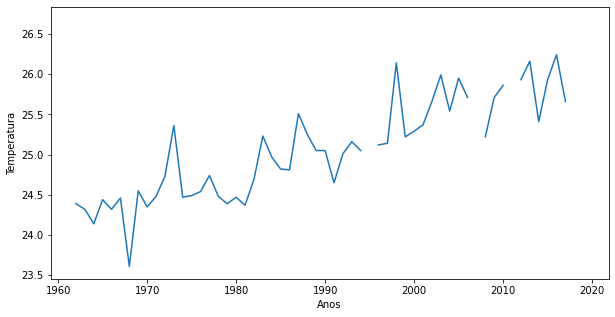

In [331]:
plt.plot(df_year.YEAR, df_year.metANN)
plt.xlabel('Anos')
plt.ylabel('Temperatura')
plt.show()

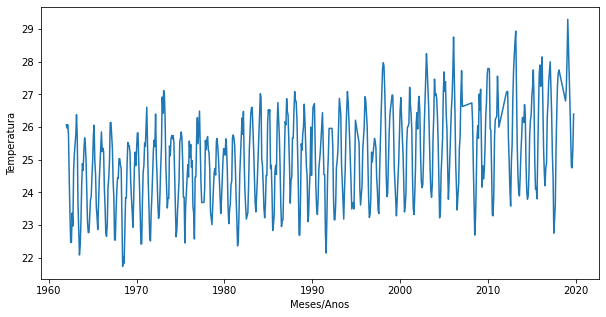

In [332]:
plt.plot(df_month.DATE, df_month.VALUE)
plt.xlabel('Meses/Anos')
plt.ylabel('Temperatura')
plt.show()

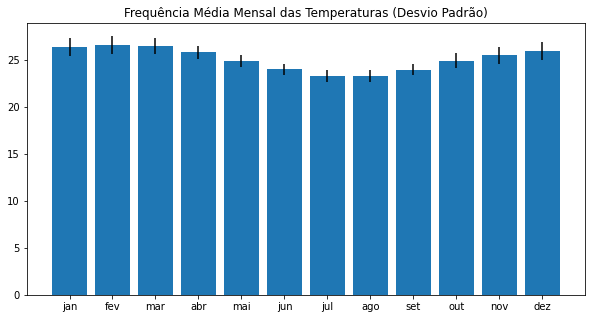

In [333]:
indice = ['jan','fev','mar','abr','mai','jun','jul','ago','set','out','nov','dez']
stats = df_month.groupby(['MONTH'], as_index=False)['VALUE'].agg(['mean', 'std'])
plt.bar(indice, stats['mean'], yerr = stats['std'])
plt.title('Frequência Média Mensal das Temperaturas (Desvio Padrão)')
plt.show()

In [334]:
df_year = df_year.dropna()

In [335]:
df_year.describe()

,YEAR,metANN
count,54.000000,54.000000
mean,1989.222222,25.079259
std,16.652573,0.647459
min,1962.000000,23.610000
25%,1975.250000,24.482500
50%,1988.500000,25.050000
75%,2002.750000,25.532500
max,2019.000000,26.680000


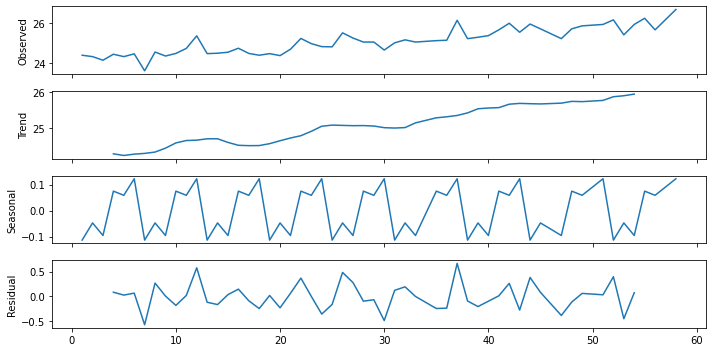

In [336]:
decomposition = seasonal_decompose(df_year.metANN , model = 'additive', freq = 6)
decomposition.plot()
plt.show()

In [337]:
df_month.describe()

,YEAR,MONTH,VALUE
count,612.000000,612.000000,612.000000
mean,1989.214052,6.496732,25.072353
std,16.685350,3.452031,1.398251
min,1962.000000,1.000000,21.730000
25%,1974.750000,4.000000,23.957500
50%,1988.500000,7.000000,25.030000
75%,2003.000000,9.000000,26.070000
max,2019.000000,12.000000,29.300000


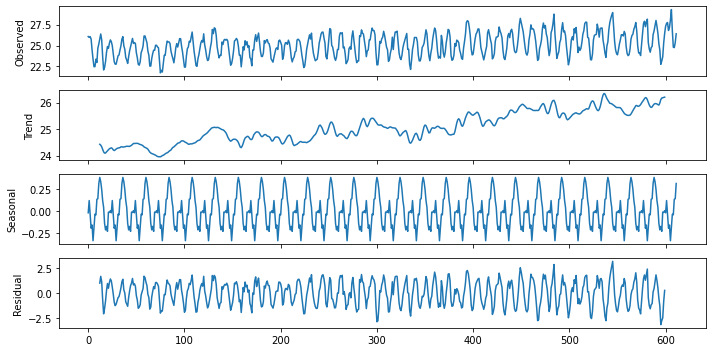

In [338]:
decomposition = seasonal_decompose(tmp.VALUE , model = 'additive', freq = 24)
decomposition.plot()
plt.show()

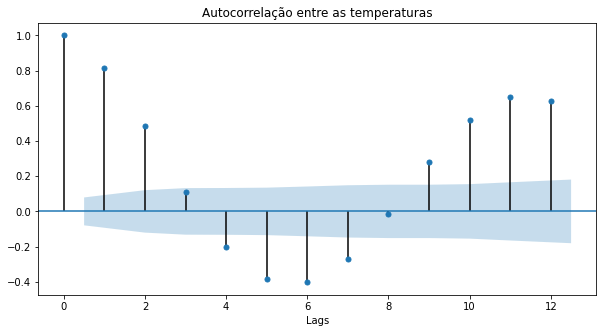

In [339]:
plot_acf(df_month.VALUE,lags=12)
plt.title('Autocorrelação entre as temperaturas')
plt.xlabel('Lags')
plt.show()

## **5. Organização dos dados para modelagem**

In [340]:
def organizarDados(sequence,n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [341]:
X,y = organizarDados(df_month.VALUE,36)

In [342]:
X[:10]

array([[26.07, 25.97, 26.07, 25.77, 24.47, 23.37, 22.47, 22.47, 23.37,
        22.97, 24.67, 25.18, 25.78, 26.38, 25.68, 23.68, 22.08, 22.38,
        23.08, 24.18, 24.88, 24.67, 25.27, 25.67, 25.47, 24.97, 24.07,
        23.07, 22.77, 22.77, 23.27, 23.77, 23.87, 24.46, 24.96, 25.76],
       [25.97, 26.07, 25.77, 24.47, 23.37, 22.47, 22.47, 23.37, 22.97,
        24.67, 25.18, 25.78, 26.38, 25.68, 23.68, 22.08, 22.38, 23.08,
        24.18, 24.88, 24.67, 25.27, 25.67, 25.47, 24.97, 24.07, 23.07,
        22.77, 22.77, 23.27, 23.77, 23.87, 24.46, 24.96, 25.76, 26.06],
       [26.07, 25.77, 24.47, 23.37, 22.47, 22.47, 23.37, 22.97, 24.67,
        25.18, 25.78, 26.38, 25.68, 23.68, 22.08, 22.38, 23.08, 24.18,
        24.88, 24.67, 25.27, 25.67, 25.47, 24.97, 24.07, 23.07, 22.77,
        22.77, 23.27, 23.77, 23.87, 24.46, 24.96, 25.76, 26.06, 24.96],
       [25.77, 24.47, 23.37, 22.47, 22.47, 23.37, 22.97, 24.67, 25.18,
        25.78, 26.38, 25.68, 23.68, 22.08, 22.38, 23.08, 24.18, 24.88,
   

In [343]:
y[:10]

array([26.06, 24.96, 24.56, 23.56, 23.26, 22.86, 23.66, 24.36, 24.86,
       25.35])

In [344]:
# dividindo dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

## **6. Treinando os modelos e fazendo previsão**

In [345]:
#definindo modelo de regressão linear
linear = LinearRegression()
linear.fit(X_train,y_train)
pred_linear = linear.predict(X_test)

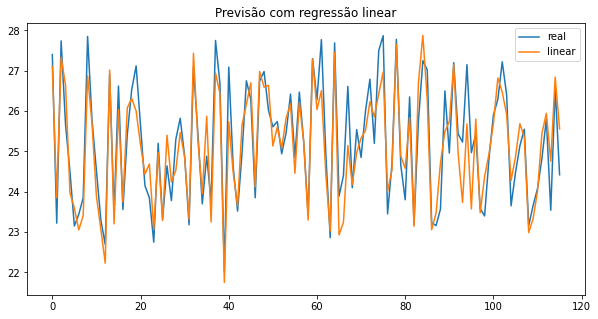

In [346]:
#plotando resultados da reg 
plt.plot(y_test,label='real')
plt.plot(pred_linear,label='linear')
plt.legend()
plt.title('Previsão com regressão linear')
plt.show()

In [347]:
#definindo modelo de árvore de decisão
arvore = DecisionTreeRegressor()
arvore.fit(X_train,y_train)
pred_arvore = arvore.predict(X_test)

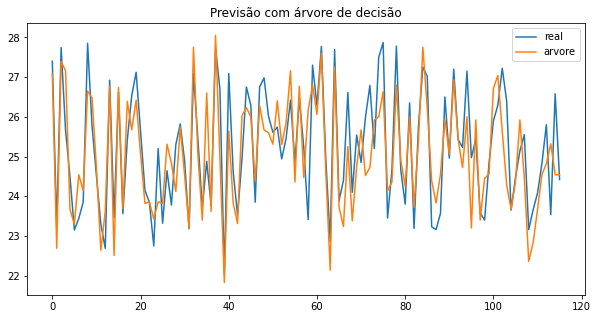

In [348]:
#plotando resultados da árvore de decisão
plt.plot(y_test,label='real')
plt.plot(pred_arvore,label='arvore')
plt.legend()
plt.title('Previsão com árvore de decisão')
plt.show()

In [349]:
#definindo modelo de random forest
floresta = RandomForestRegressor(n_estimators=100)
floresta.fit(X_train,y_train)
pred_floresta = floresta.predict(X_test)

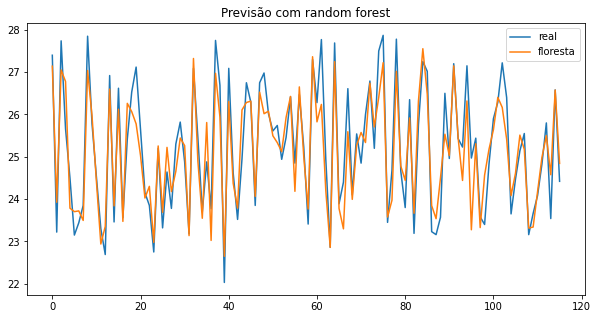

In [350]:
#plotando resultados da random forest
plt.plot(y_test,label='real')
plt.plot(pred_floresta,label='floresta')
plt.legend()
plt.title('Previsão com random forest')
plt.show()

In [353]:
#define modelo MLP
mlp = MLPRegressor(hidden_layer_sizes=(500),activation='logistic',max_iter=10000)
mlp.fit(X_train,y_train)
pred_mlp = mlp.predict(X_test)

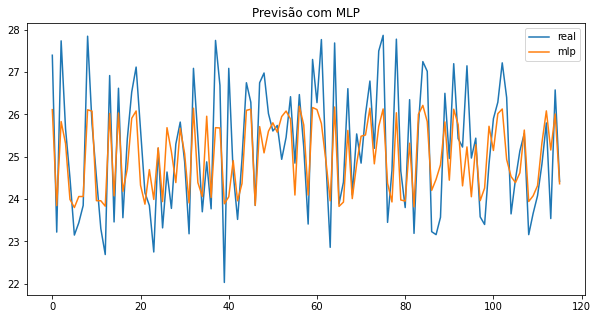

In [354]:
#plotando resultados da MLP
plt.plot(y_test,label='real')
plt.plot(pred_mlp,label='mlp')
plt.legend()
plt.title('Previsão com MLP')
plt.show()

In [356]:
print('MAE')
print('\tRegressão Linear:',round(mean_absolute_error(y_test,pred_linear),2))
print('\tArvore de Decisão:',round(mean_absolute_error(y_test,pred_arvore),2))
print('\tRandom Forest:',round(mean_absolute_error(y_test,pred_floresta),2))
print('\tMLP:',round(mean_absolute_error(y_test,pred_mlp),2))

MAE
	Regressão Linear: 0.5
	Arvore de Decisão: 0.71
	Random Forest: 0.48
	MLP: 0.78


In [357]:


print('MSE')
print('\tRegressão Linear:',round(mean_squared_error(y_test,pred_linear),2))
print('\tArvore de Decisão:',round(mean_squared_error(y_test,pred_arvore),2))
print('\tRandom Forest:',round(mean_squared_error(y_test,pred_floresta),2))
print('\tMLP:',round(mean_squared_error(y_test,pred_mlp),2))



MSE
	Regressão Linear: 0.38
	Arvore de Decisão: 0.78
	Random Forest: 0.35
	MLP: 0.9


In [358]:
print('RMSE')
print('\tRegressão Linear:',round(mean_squared_error(y_test,pred_linear)**(1/2),2))
print('\tArvore de Decisão:',round(mean_squared_error(y_test,pred_arvore)**(1/2),2))
print('\tRandom Forest:',round(mean_squared_error(y_test,pred_floresta)**(1/2),2))
print('\tMLP:',round(mean_squared_error(y_test,pred_mlp)**(1/2),2))

RMSE
	Regressão Linear: 0.62
	Arvore de Decisão: 0.88
	Random Forest: 0.59
	MLP: 0.95


In [359]:


def mean_absolute_percentage_error(y_test,y_pred):
  y_test=y_test
  erro = 0
  for i in range(len(y_test)):
    erro += abs(y_test[i]-y_pred[i])/y_test[i]
  return erro/len(y_test)



In [360]:
print('MAPE')
print('\tRegressão Linear:',round(mean_absolute_percentage_error(y_test,pred_linear)**(1/2),2))
print('\tArvore de Decisão:',round(mean_absolute_percentage_error(y_test,pred_arvore)**(1/2),2))
print('\tRandom Forest:',round(mean_absolute_percentage_error(y_test,pred_floresta)**(1/2),2))
print('\tMLP:',round(mean_absolute_percentage_error(y_test,pred_mlp)**(1/2),2))

MAPE
	Regressão Linear: 0.14
	Arvore de Decisão: 0.17
	Random Forest: 0.14
	MLP: 0.17


## **8. Análise dos Resultados**

A plotagem da temperatura ao longo dos anos nos mostra uma tendência de aumento da temperatura média de 1962 para 2020.

Maio a outubro apresentam as médias mais baixas.

Para as tentativas de prever a temperatura, foram utilizados dados de 36 meses anteriores a data almejada.


Visualmente, o modelo que parece melhor ajustado é o de Árvore de Decisão. Porém, os testes demonstraram que a MLP tem os melhores valores de predição.
Entretanto, na análise MAPE, a MLP e a Árvore de Decisão apresentaram resultados iguais